In [ ]:
import urllib.request

def download_files():
    # URLs for the model weights and configuration files
    prototxt_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
    caffemodel_url = "https://github.com/opencv/opencv_3rdparty/blob/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel?raw=true"

    # Local file paths
    prototxt_path = "deploy.prototxt"
    caffemodel_path = "res10_300x300_ssd_iter_140000_fp16.caffemodel"

    # Downloading files
    urllib.request.urlretrieve(prototxt_url, prototxt_path)
    urllib.request.urlretrieve(caffemodel_url, caffemodel_path)
    print("Files downloaded successfully")

isDownloaded = !ls deploy.prototxt

if isDownloaded:
  download_files()


!ls deploy.prototxt

Files downloaded successfully
deploy.prototxt


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from google.colab.patches import cv2_imshow

In [ ]:
# Load the face detection model
modelFile = "res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/ECE551_p2_dataset/'

images = []
labels = []
label_map = {}  # To map person names to integers
label_counter = 0

for person_name in os.listdir(path):
    person_folder = os.path.join(path, person_name)
    if os.path.isdir(person_folder):
        for image_filename in os.listdir(person_folder):
            if image_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(person_folder, image_filename)
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (224, 224))
                    image = img_to_array(image)
                    images.append(image)
                    if person_name not in label_map:
                        label_map[person_name] = label_counter
                        label_counter += 1
                    labels.append(label_map[person_name])

# images = np.array(images)
# labels = np.array(labels)



print('Input Images')
print(type(images))
print(labels)
print(len(images))

Input Images
<class 'list'>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
data_gen = ImageDataGenerator(
    rotation_range=40,       # Random rotations from 0 to 40 degrees
    width_shift_range=0.2,   # Random horizontal shifts up to 20% of the width
    height_shift_range=0.2,  # Random vertical shifts up to 20% of the height
    shear_range=0.2,         # Shear transformations
    zoom_range=0.2,          # Random zooming up to 20%
    horizontal_flip=True,    # Random horizontal flipping
    fill_mode='nearest',     # Strategy to fill newly created pixels
    brightness_range=[0.5, 1.5],  # Random brightness adjustments
)

# Additional function for noise injection
def add_noise(img):
    '''Inject random noise to an image'''
    variance = np.random.uniform(0.01, 0.05)
    noise = np.random.normal(0, variance, img.shape)
    img_noisy = img + noise
    np.clip(img_noisy, 0, 1, out=img_noisy)
    return img_noisy

In [ ]:
# Initialize arrays to hold the augmented data
augmented_images = []
augmented_labels = []

# Define number of augmentations per image
augmentations_per_image = 1

for img, label in zip(images, labels):
    img = np.expand_dims(img, axis=0)  # Reshape to (1, height, width, channels)
    # Generate multiple augmented images for the single image
    for _ in range(augmentations_per_image):
        aug_img = data_gen.random_transform(img[0])  # Apply random transformation
        augmented_images.append(aug_img)
        augmented_labels.append(label)  # Append the same label for the augmented image


# Convert augmented images and labels to numpy arrays
# augmented_images = np.array(augmented_images)
# augmented_labels = np.array(augmented_labels)

print('Augmented Only')
print(type(augmented_images))
print(augmented_labels)
print(len(augmented_labels))


Augmented Only
<class 'list'>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Input+Augmented
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
2344


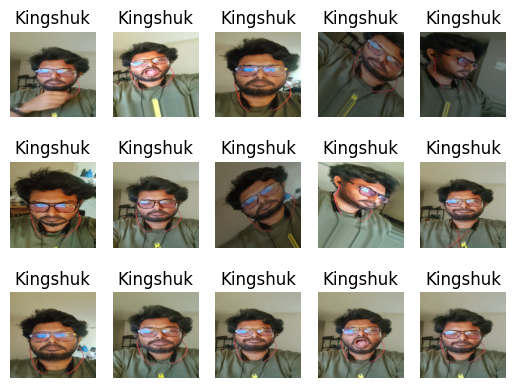

In [ ]:
# Optionally, concatenate the original and augmented datasets
images = np.concatenate((images, augmented_images), axis=0)
labels = np.concatenate((labels, augmented_labels), axis=0)



print('Input+Augmented')
print(type(images))
print(labels)
print(len(labels))

for i in range(15):
    plt.subplot(3, 5, i + 1)
    idx = np.random.randint(0, len(images))
    plt.imshow(images[idx].astype('uint8'))
    plt.title(list(label_map.keys())[list(label_map.values()).index(labels[idx])])
    plt.axis('off')
plt.show()

In [ ]:
face_images = []
face_labels = []
count=0
for image, label in zip(images, labels):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                 (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    count+=1
    # Draw detections on the image
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        # Filter out weak detections by ensuring the 'confidence' is greater than a minimum threshold
        if confidence > 0.5:
            # Compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Ensure the bounding box fits within the dimensions of the frame
            startX, startY = max(0, startX), max(0, startY)
            endX, endY = min(w - 1, endX), min(h - 1, endY)

            # Extract the face ROI
            face = image[startY:endY, startX:endX]
            # You might want to save or process the face in this block
            # face = np.expand_dims(face, axis=0)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face_images.append(face)
            face_labels.append(label)


print('ALL: Input+Augmented')
print(type(face_images))
print('face label', face_labels)
print('face count',len(face_labels))
print('total count',count)


ALL: Input+Augmented
<class 'list'>
face label [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
from itertools import groupby
[len(list(group)) for key, group in groupby(sorted(face_labels))]

[1736]

ALL: Input+Augmented+face
<class 'list'>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

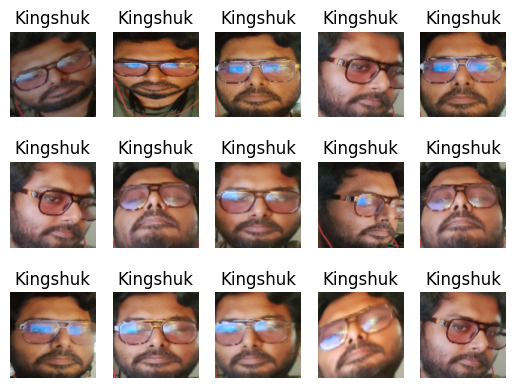

In [ ]:
# Optionally, concatenate the original and augmented datasets
# images = np.concatenate((images, face_images), axis=0)
# labels = np.concatenate((labels, face_labels), axis=0)

images = []
labels = []

images = face_images
labels = face_labels

# garbage collection to save memory
face_images = []
face_labels = []

print('ALL: Input+Augmented+face')
print(type(images))
print(labels)
print(len(labels))

for i in range(15):
    plt.subplot(3, 5, i + 1)
    idx = np.random.randint(0, len(images))
    plt.imshow(images[idx].astype('uint8'))
    plt.title(list(label_map.keys())[list(label_map.values()).index(labels[idx])])
    plt.axis('off')
plt.show()

In [ ]:
np.save(os.path.join(path, 'data.npy'), images)
np.save(os.path.join(path, 'labels.npy'), labels)

In [ ]:
images = np.array(images)
labels = np.array(labels)

Train

In [ ]:
#Normalize and split
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=16)
# Rescaling layer
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
#tried adam
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [ ]:
print('Train Image:', len(train_images))
print('Test Image:', len(test_images))
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32, use_multiprocessing=True)

Train Image: 1413
Test Image: 354
Epoch 1/10
45/45 [==============================] - 409s 9s/step - loss: 0.0443 - accuracy: 0.9809 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 2/10
45/45 [==============================] - 403s 9s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 3/10
45/45 [==============================] - 386s 9s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 8.7773e-04 - val_accuracy: 1.0000
Epoch 4/10
45/45 [==============================] - 359s 8s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 6.0229e-04 - val_accuracy: 1.0000
Epoch 5/10
45/45 [==============================] - 357s 8s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 4.4454e-04 - val_accuracy: 1.0000
Epoch 6/10
45/45 [==============================] - 432s 10s/step - loss: 9.2543e-04 - accuracy: 1.0000 - val_loss: 3.4421e-04 - val_accuracy: 1.0000
Epoch 7/10
45/45 [==============================] - 368s 8s/step - loss: 7.1197e-04 - accuracy: 1.0

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/ECE551_p2_dataset/kmodel2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


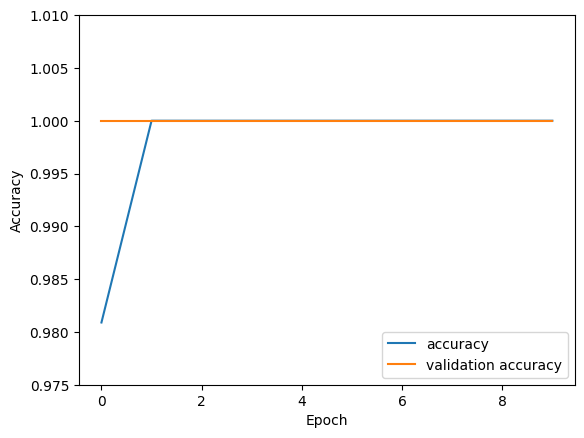

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.975, 1.01])
plt.legend(loc='lower right')
plt.show()

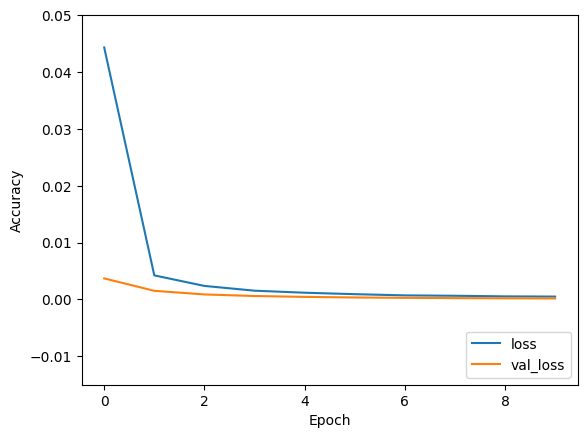

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([-0.015, 0.05])
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose='auto')
print('\nTest accuracy:', test_acc)



11/11 [==============================] - 63s 6s/step - loss: 1.7190e-04 - accuracy: 1.0000

Test accuracy: 1.0


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ECE551_p2_dataset/kmodel.h5')


In [ ]:
def crop_face(image):
    notAface = []
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                 (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    # Draw detections on the image
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        # Filter out weak detections by ensuring the 'confidence' is greater than a minimum threshold
        if confidence > 0.5:
            # Compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Ensure the bounding box fits within the dimensions of the frame
            startX, startY = max(0, startX), max(0, startY)
            endX, endY = min(w - 1, endX), min(h - 1, endY)

            # Extract the face ROI
            face = image[startY:endY, startX:endX]
            # You might want to save or process the face in this block
            # face = np.expand_dims(face, axis=0)
            face = cv2.resize(face, (224, 224))
            # face = img_to_array(face)
            return face
    return notAface


In [ ]:
predImages= []
predLabel =[]
# label_map = {0:'unknown', 'Kingshuk'}  # To map person names to integers
def prnt(a):
  if a > 0.11:
    # print('Kingshuk')
    predLabel.append("Kingshuk")
  else:
    # print('Unknown Person')
    predLabel.append("Unknown")


def predict(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_face(image) #Should have put an execption handler
    # plt.imshow(image)
    predImages.append(image)

    # plt.show()
    # face = img_to_array(face)
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    preds = model.predict(image)

    print(preds)
    prnt(preds)
    return preds

1/1 [==============================] - 0s 323ms/step
[[0.13329521]]
1/1 [==============================] - 0s 380ms/step
[[0.10236347]]
1/1 [==============================] - 0s 220ms/step
[[0.13189204]]
1/1 [==============================] - 0s 223ms/step
[[0.12881276]]
1/1 [==============================] - 0s 204ms/step
[[0.09088074]]
5


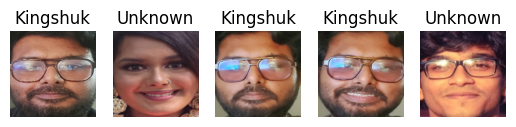

In [ ]:
a = predict('/content/drive/MyDrive/Colab Notebooks/testIMG/Kingshuk_001.jpg')
c = predict('/content/drive/MyDrive/Colab Notebooks/testIMG/Synthia.jpg')
b = predict('/content/drive/MyDrive/Colab Notebooks/ECE551_p2_dataset/Kingshuk/Kingshuk_1000.jpg')
d = predict('/content/drive/MyDrive/Colab Notebooks/ECE551_p2_dataset/Kingshuk/Kingshuk_1101.jpg')
d = predict('/content/drive/MyDrive/Colab Notebooks/testIMG/shakib2.jpg')


print(len(predImages))
for i in range(len(predImages)):
    plt.subplot(1, len(predImages), i+1)
    plt.imshow(predImages[i].astype('uint8'))
    plt.title(predLabel[i])
    plt.axis('off')
plt.show()

predImages= []
predLabel =[]
